# PolyHedgeRL: Complete Training and Evaluation Notebook

## Overview
This notebook demonstrates the complete PolyHedgeRL training pipeline with comprehensive visualizations and analysis.

**Contents:**
1. Environment Setup and Data Loading
2. Synthetic Option Chain Generation
3. RL Environment Initialization
4. PPO Agent Training
5. Performance Evaluation
6. Comprehensive Visualizations
7. Results Export

**Author**: Parth Dambhare  
**Date**: October 18, 2025  
**Project**: Multi-Layered Option Hedging Using Deep RL

## 1. Import Required Libraries

In [26]:
# Import required libraries
import sys
import os
import warnings
import importlib
warnings.filterwarnings('ignore')

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import torch

# RL libraries
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback

# Project imports
import src.utils.data_utils
import src.environment.option_pricing
import src.environment.Multi_asset_env
import src.agents.ppo_agent
import src.agents.evaluation

# Reload modules to get latest changes
importlib.reload(src.utils.data_utils)
importlib.reload(src.environment.option_pricing)
importlib.reload(src.environment.Multi_asset_env)
importlib.reload(src.agents.ppo_agent)
importlib.reload(src.agents.evaluation)

from src.utils.data_utils import download_market_data
from src.environment.option_pricing import create_synthetic_option_chain
from src.environment.Multi_asset_env import MultiAsset21DeepHedgingEnv
from src.agents.ppo_agent import PPOAgent, get_device
from src.agents.evaluation import evaluate_model, backtest_series
from src.config.settings import get_config

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("All libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"PyTorch version: {torch.__version__}")
print()

# Check device availability
print("=" * 60)
print("DEVICE INFORMATION")
print("=" * 60)
device = get_device()
print(f"Selected device: {device.upper()}")

if torch.backends.mps.is_available():
    print("✓ MPS (Apple Silicon GPU) is AVAILABLE and ENABLED")
    print("  → Training will use Metal Performance Shaders")
    print("  → Expected 2-3x speedup compared to CPU")
elif torch.cuda.is_available():
    print(f"✓ CUDA GPU: {torch.cuda.get_device_name(0)}")
else:
    print("✓ CPU training (no GPU acceleration)")
print("=" * 60)

All libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.2.2


## 2. Configuration and Setup

In [ ]:
import os

def create_directories():
    """Create necessary directories for results."""
    directories = [
        '../results',
        '../results/plots',
        '../results/models',
        '../results/logs',
        '../results/reports'
    ]
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
    print("✓ Directories created successfully")

# Create necessary directories
create_directories()

# Training configuration
TRAINING_TIMESTEPS = 5000  # For quick demonstration (increase to 50000+ for real training)
EVAL_FREQ = 1000
SAVE_FREQ = 2000

# Visualization configuration
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10

# Output configuration
RESULTS_DIR = '../results'
PLOTS_DIR = os.path.join(RESULTS_DIR, 'plots')
REPORTS_DIR = os.path.join(RESULTS_DIR, 'reports')

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

print(f"Configuration complete!")
print(f"Training timesteps: {TRAINING_TIMESTEPS:,}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Plots directory: {PLOTS_DIR}")


Configuration complete!
Training timesteps: 5,000
Results directory: ../results
Plots directory: ../results/plots


## 3. Data Loading and Exploration

In [22]:
# Load market data
print("Downloading/loading market data...")
data_config = get_config('data')

spot_data = download_market_data(
    symbol=data_config['symbol'],
    start_date=data_config['start_date'],
    end_date=data_config['end_date'],
    interval=data_config['interval']
)

print(f"\nData loaded successfully!")
print(f"Total trading days: {len(spot_data):,}")
print(f"Date range: {spot_data['date'].min()} to {spot_data['date'].max()}")
print(f"\nData preview:")
print(spot_data.head())
print(f"\nData statistics:")
print(spot_data[['close', 'return', 'realized_vol_10d']].describe())

Downloading/loading market data...

Data loaded successfully!
Total trading days: 3,725
Date range: 2010-03-16 00:00:00 to 2024-12-31 00:00:00

Data preview:
        date        close    return  realized_vol_10d  realized_vol_20d  \
0 2010-03-16  1159.459961  0.007779          0.070833          0.086765   
1 2010-03-17  1166.209961  0.005822          0.069166          0.087274   
2 2010-03-18  1165.829956 -0.000326          0.072787          0.086917   
3 2010-03-19  1159.900024 -0.005086          0.059416          0.091128   
4 2010-03-22  1165.810059  0.005095          0.060264          0.090785   

        sma_20       sma_50  momentum_5d  momentum_20d  
0  1123.997491  1113.826594     0.016669      0.058993  
1  1127.332489  1114.490994     0.017982      0.060663  
2  1130.286487  1115.077192     0.013554      0.053381  
3  1132.822986  1115.532393     0.008617      0.045737  
4  1135.712988  1116.014795     0.013298      0.052166  

Data statistics:
             close       return

### 3.1 Visualize Market Data

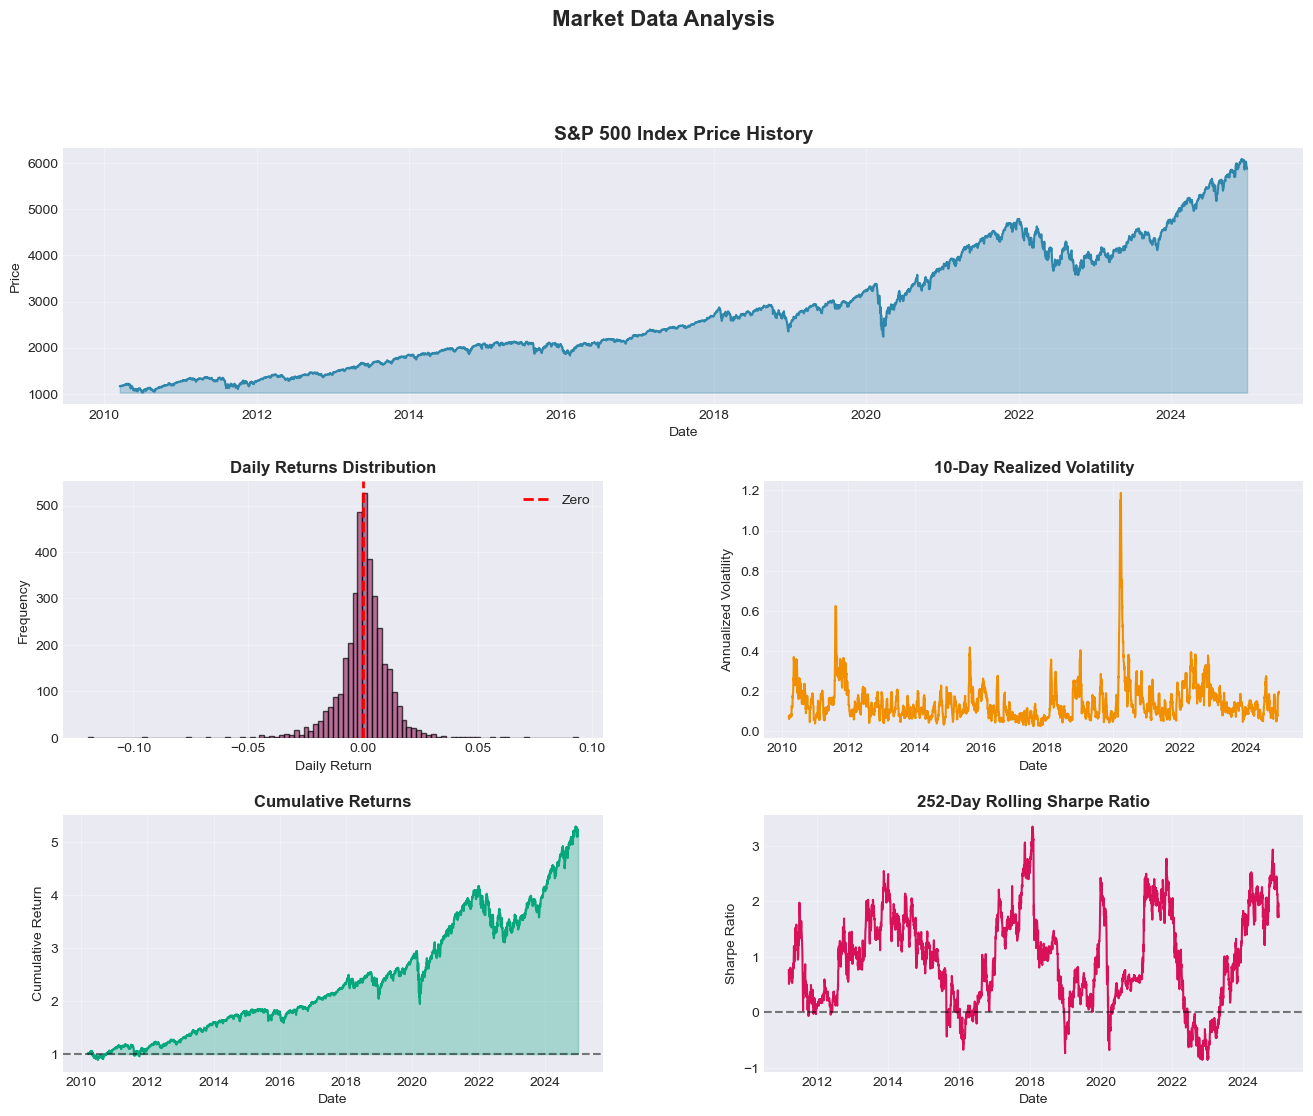

Market data visualizations created!


In [6]:
# Create comprehensive market data visualizations
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.3)

# Convert to numpy arrays to ensure 1D
dates = spot_data['date'].values
close_prices = spot_data['close'].values.flatten()
returns = spot_data['return'].values.flatten()
realized_vol = spot_data['realized_vol_10d'].values.flatten()

# 1. Price chart
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(dates, close_prices, linewidth=1.5, color='#2E86AB')
ax1.fill_between(dates, close_prices.min(), close_prices, alpha=0.3, color='#2E86AB')
ax1.set_title('S&P 500 Index Price History', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.grid(True, alpha=0.3)

# 2. Returns distribution
ax2 = fig.add_subplot(gs[1, 0])
returns_clean = returns[~np.isnan(returns)]
ax2.hist(returns_clean, bins=100, alpha=0.7, color='#A23B72', edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
ax2.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Volatility over time
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(dates, realized_vol, linewidth=1.5, color='#F18F01')
ax3.set_title('10-Day Realized Volatility', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Annualized Volatility')
ax3.grid(True, alpha=0.3)

# 4. Cumulative returns
ax4 = fig.add_subplot(gs[2, 0])
returns_filled = np.nan_to_num(returns, 0)
cumulative_returns = np.cumprod(1 + returns_filled)
ax4.plot(dates, cumulative_returns, linewidth=1.5, color='#06A77D')
ax4.fill_between(dates, 1, cumulative_returns, alpha=0.3, color='#06A77D')
ax4.axhline(y=1, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Cumulative Returns', fontsize=12, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Cumulative Return')
ax4.grid(True, alpha=0.3)

# 5. Rolling Sharpe ratio
ax5 = fig.add_subplot(gs[2, 1])
rolling_sharpe = (spot_data['return'].rolling(252).mean() / spot_data['return'].rolling(252).std()) * np.sqrt(252)
ax5.plot(dates, rolling_sharpe.values.flatten(), linewidth=1.5, color='#D81159')
ax5.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax5.set_title('252-Day Rolling Sharpe Ratio', fontsize=12, fontweight='bold')
ax5.set_xlabel('Date')
ax5.set_ylabel('Sharpe Ratio')
ax5.grid(True, alpha=0.3)

plt.suptitle('Market Data Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.savefig(os.path.join(PLOTS_DIR, '01_market_data_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Market data visualizations created!")

## 4. Generate Synthetic Option Chain

In [23]:
# Generate synthetic option chain
print("Generating synthetic option chain...")
option_config = get_config('option')

option_chain = create_synthetic_option_chain(spot_data, option_config)

print(f"\nOption chain generated successfully!")
print(f"Total option contracts: {len(option_chain):,}")
print(f"Strike offsets: {option_config['strike_offsets']}")
print(f"Expiry days: {option_config['expiry_days']}")
print(f"Option types: {option_config['option_types']}")
print(f"\nOption chain preview:")
print(option_chain.head(10))
print(f"\nOption statistics:")
print(option_chain[['bid', 'ask', 'iv', 'open_interest']].describe())

Generating synthetic option chain...

Option chain generated successfully!
Total option contracts: 74,500
Strike offsets: [-100, -50, 0, 50, 100]
Expiry days: [30, 60]
Option types: ['call', 'put']

Option chain preview:
        date     expiry  expiry_days  strike  strike_offset  type  \
0 2010-03-16 2010-04-15           30    1059           -100  call   
1 2010-03-16 2010-04-15           30    1059           -100   put   
2 2010-03-16 2010-04-15           30    1109            -50  call   
3 2010-03-16 2010-04-15           30    1109            -50   put   
4 2010-03-16 2010-04-15           30    1159              0  call   
5 2010-03-16 2010-04-15           30    1159              0   put   
6 2010-03-16 2010-04-15           30    1209             50  call   
7 2010-03-16 2010-04-15           30    1209             50   put   
8 2010-03-16 2010-04-15           30    1259            100  call   
9 2010-03-16 2010-04-15           30    1259            100   put   

          spot  the

### 4.1 Visualize Option Chain Characteristics

Analyzing 100 sample options


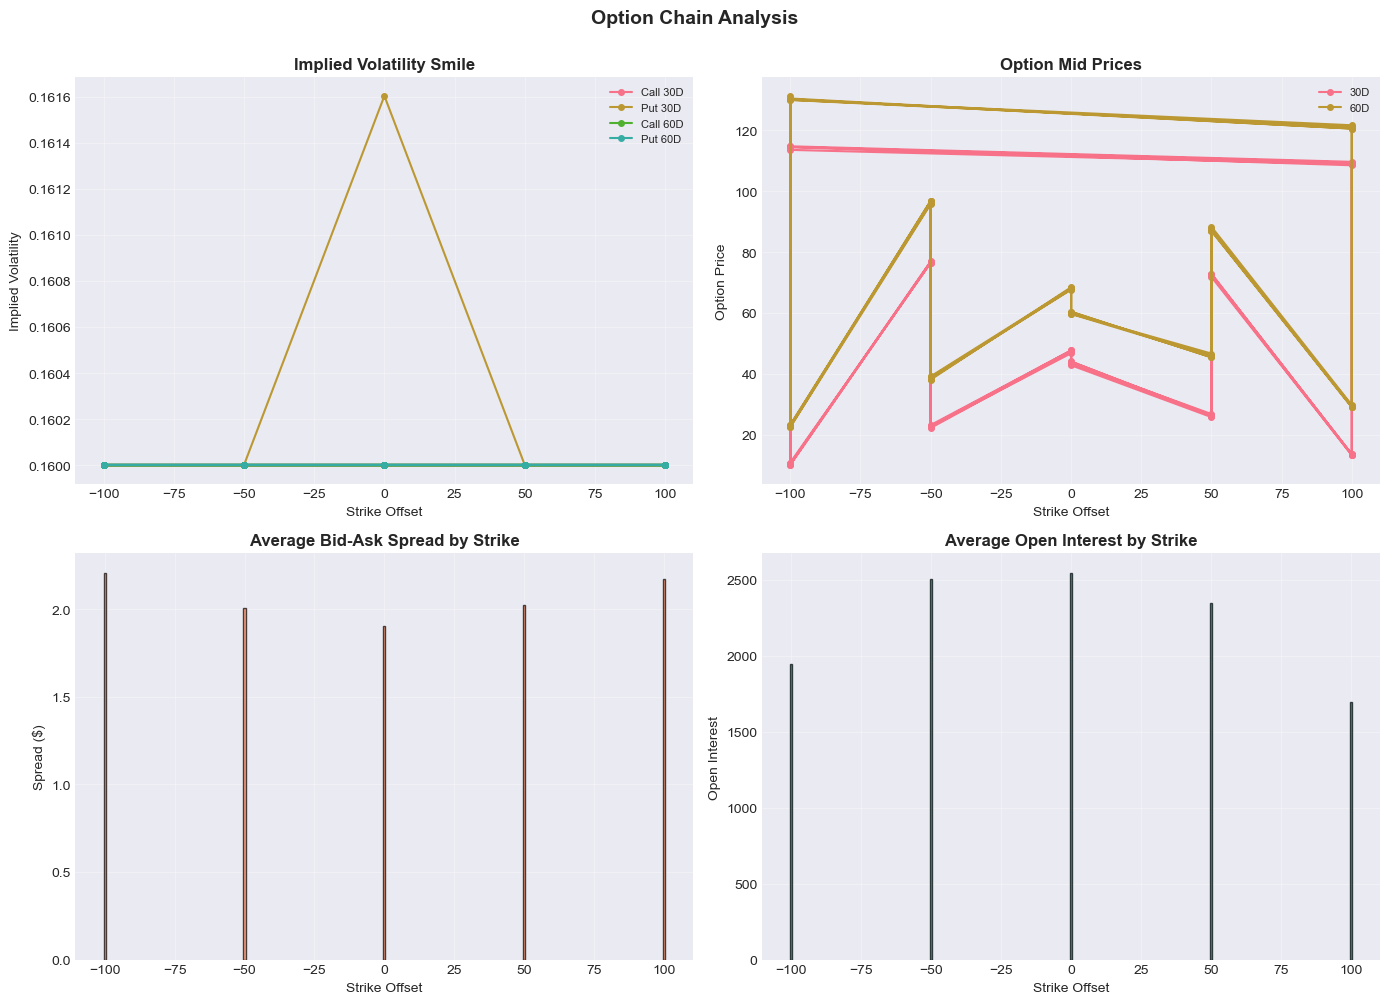

Option chain visualizations created!


In [13]:
# Sample options for visualization - use middle record set
# Since we generate options for each date, let's take options from the middle of the dataset
total_records = len(option_chain)
mid_start = (total_records // 2) - 50
mid_end = mid_start + 100

# Take a slice of options from the middle
sample_options = option_chain.iloc[mid_start:mid_end].copy()

print(f"Analyzing {len(sample_options)} sample options")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Implied Volatility Smile
for expiry in option_config['expiry_days']:
    for opt_type in ['call', 'put']:
        data = sample_options[(sample_options['expiry_days'] == expiry) & 
                              (sample_options['type'] == opt_type)]
        if len(data) > 0:
            axes[0, 0].plot(data['strike_offset'], data['iv'], 
                           marker='o', label=f'{opt_type.capitalize()} {expiry}D', markersize=4)

axes[0, 0].set_title('Implied Volatility Smile', fontweight='bold')
axes[0, 0].set_xlabel('Strike Offset')
axes[0, 0].set_ylabel('Implied Volatility')
axes[0, 0].legend(fontsize=8)
axes[0, 0].grid(True, alpha=0.3)

# 2. Option Prices
for expiry in option_config['expiry_days']:
    data = sample_options[sample_options['expiry_days'] == expiry]
    if len(data) > 0:
        axes[0, 1].plot(data['strike_offset'], data['mid'], 
                       marker='o', label=f'{expiry}D', markersize=4)

axes[0, 1].set_title('Option Mid Prices', fontweight='bold')
axes[0, 1].set_xlabel('Strike Offset')
axes[0, 1].set_ylabel('Option Price')
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# 3. Bid-Ask Spread
sample_options['spread'] = sample_options['ask'] - sample_options['bid']
spread_by_strike = sample_options.groupby('strike_offset')['spread'].mean()
axes[1, 0].bar(spread_by_strike.index, spread_by_strike.values, 
              color='coral', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Average Bid-Ask Spread by Strike', fontweight='bold')
axes[1, 0].set_xlabel('Strike Offset')
axes[1, 0].set_ylabel('Spread ($)')
axes[1, 0].grid(True, alpha=0.3)

# 4. Open Interest
oi_by_strike = sample_options.groupby('strike_offset')['open_interest'].mean()
axes[1, 1].bar(oi_by_strike.index, oi_by_strike.values, 
              color='teal', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Average Open Interest by Strike', fontweight='bold')
axes[1, 1].set_xlabel('Strike Offset')
axes[1, 1].set_ylabel('Open Interest')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Option Chain Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '02_option_chain_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Option chain visualizations created!")

## 5. Initialize RL Environment

In [27]:
# Build asset universe (20 options)
strikes = option_config['strike_offsets']
expiries = option_config['expiry_days']
types = option_config['option_types']

asset_universe = [
    {'strike_offset': s, 'expiry_days': e, 'type': t}
    for e in expiries for s in strikes for t in types
]

print(f"Asset universe created: {len(asset_universe)} options")
assert len(asset_universe) == 20, f"Expected 20 options, got {len(asset_universe)}"

# Initialize environment
env_config = get_config('env')

env = MultiAsset21DeepHedgingEnv(
    spot_data=spot_data,
    option_chain=option_chain,
    asset_universe=asset_universe,
    transaction_cost=env_config['transaction_cost'],
    risk_penalty=env_config['risk_penalty'],
    episode_length=env_config['episode_length']
)

print(f"\nEnvironment initialized successfully!")
print(f"Observation space: {env.observation_space.shape}")
print(f"Action space: {env.action_space.shape}")
print(f"Transaction cost: {env_config['transaction_cost']}")
print(f"Risk penalty: {env_config['risk_penalty']}")
print(f"Episode length: {env_config['episode_length']} steps")

# Test environment
obs, info = env.reset()
print(f"\nEnvironment test:")
print(f"Initial observation shape: {obs.shape}")
print(f"Initial portfolio value: ${info['portfolio_value']:,.2f}")

Asset universe created: 20 options

Environment initialized successfully!
Observation space: (107,)
Action space: (21,)
Transaction cost: 0.001
Risk penalty: 0.01
Episode length: 200 steps

Environment test:
Initial observation shape: (107,)
Initial portfolio value: $100,000.00


## 6. Train PPO Agent

In [ ]:
# Create evaluation environment
eval_env = MultiAsset21DeepHedgingEnv(
    spot_data=spot_data,
    option_chain=option_chain,
    asset_universe=asset_universe,
    transaction_cost=env_config['transaction_cost'],
    risk_penalty=env_config['risk_penalty'],
    episode_length=env_config['episode_length']
)

# Initialize PPO agent with auto device detection (MPS/CUDA/CPU)
print("Creating PPO agent...")
agent = PPOAgent(env, device='auto')  # Will automatically use MPS on M2 Mac
agent.create_model()

print("\nPPO Agent created successfully!")
print(f"Device: {agent.device.upper()}")
print(f"Policy network: MLP")
print(f"Learning rate: {get_config('ppo')['learning_rate']}")
print(f"Batch size: {get_config('ppo')['batch_size']}")

if agent.device == 'mps':
    print("\n🚀 Apple Silicon GPU acceleration ENABLED!")
    print("   Training will be 2-3x faster than CPU")

print(f"\nStarting training for {TRAINING_TIMESTEPS:,} timesteps...")
print("This may take several minutes...\n")

agent.train(
    total_timesteps=TRAINING_TIMESTEPS,
    eval_env=eval_env,
    eval_freq=EVAL_FREQ,
    save_freq=SAVE_FREQ
)

print("\nTraining completed successfully!")

Creating PPO agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

PPO Agent created successfully!
Policy network: MLP
Learning rate: 0.0003
Batch size: 64

Starting training for 5,000 timesteps...
This may take several minutes...

Eval num_timesteps=1000, episode_reward=-1140.72 +/- 721.90
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 200       |
|    mean_reward     | -1.14e+03 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
Eval num_timesteps=1000, episode_reward=-1140.72 +/- 721.90
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/              |           |
|    mean_ep_length  | 200       |
|    mean_reward     | -1.14e+03 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
New best mean reward!


## 7. Evaluate Trained Agent

In [29]:
# Evaluate the trained model
print("Evaluating trained agent over 100 episodes...")
metrics = evaluate_model(agent.model, eval_env, episodes=100, deterministic=True)

print("\nEvaluation Results:")
print("="*60)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f"{key:.<40} {value:.4f}")
    else:
        print(f"{key:.<40} {value}")
print("="*60)

# Store metrics for later use
evaluation_metrics = metrics

Evaluating trained agent over 100 episodes...

Evaluation Results:
mean_reward............................. -1977.3905
std_reward.............................. 49.1296
median_reward........................... -2000.0000
min_reward.............................. -2000.0000
max_reward.............................. -1786.9129
sharpe_ratio............................ -40.2484
mean_return............................. -0.0370
std_return.............................. 0.1726
win_rate................................ 0.3800
avg_episode_length...................... 200.0000
max_drawdown............................ -195943.0120

Evaluation Results:
mean_reward............................. -1977.3905
std_reward.............................. 49.1296
median_reward........................... -2000.0000
min_reward.............................. -2000.0000
max_reward.............................. -1786.9129
sharpe_ratio............................ -40.2484
mean_return............................. -0.0370


### 7.1 Run Detailed Backtest

In [30]:
# Run detailed backtest
print("Running detailed backtest...")
backtest_df = backtest_series(agent.model, eval_env, steps=200, deterministic=True)

print(f"\nBacktest completed!")
print(f"Total steps: {len(backtest_df)}")
print(f"Final cumulative reward: {backtest_df['cumulative_reward'].iloc[-1]:.4f}")
print(f"\nBacktest preview:")
print(backtest_df.head(10))

Running detailed backtest...

Backtest completed!
Total steps: 200
Final cumulative reward: -2000.0000

Backtest preview:
   step                                             action  reward  \
0     0  [-0.04832557588815689, 0.05917593464255333, -0...   -10.0   
1     1  [-0.014485327526926994, 0.029282784089446068, ...   -10.0   
2     2  [-0.013233818113803864, -0.007495407480746508,...   -10.0   
3     3  [-0.03243998438119888, 0.028763383626937866, 0...   -10.0   
4     4  [-0.03816142678260803, 0.06651676446199417, -0...   -10.0   
5     5  [-0.023258622735738754, 0.04404120519757271, -...   -10.0   
6     6  [-0.054736942052841187, 0.08016375452280045, -...   -10.0   
7     7  [-0.03792888671159744, 0.02452346310019493, -0...   -10.0   
8     8  [-0.031847745180130005, -0.020431693643331528,...   -10.0   
9     9  [-0.007002687081694603, 0.05891973152756691, 0...   -10.0   

   cumulative_reward  
0              -10.0  
1              -20.0  
2              -30.0  
3              

## 8. Comprehensive Visualizations

### 8.1 Performance Metrics Dashboard

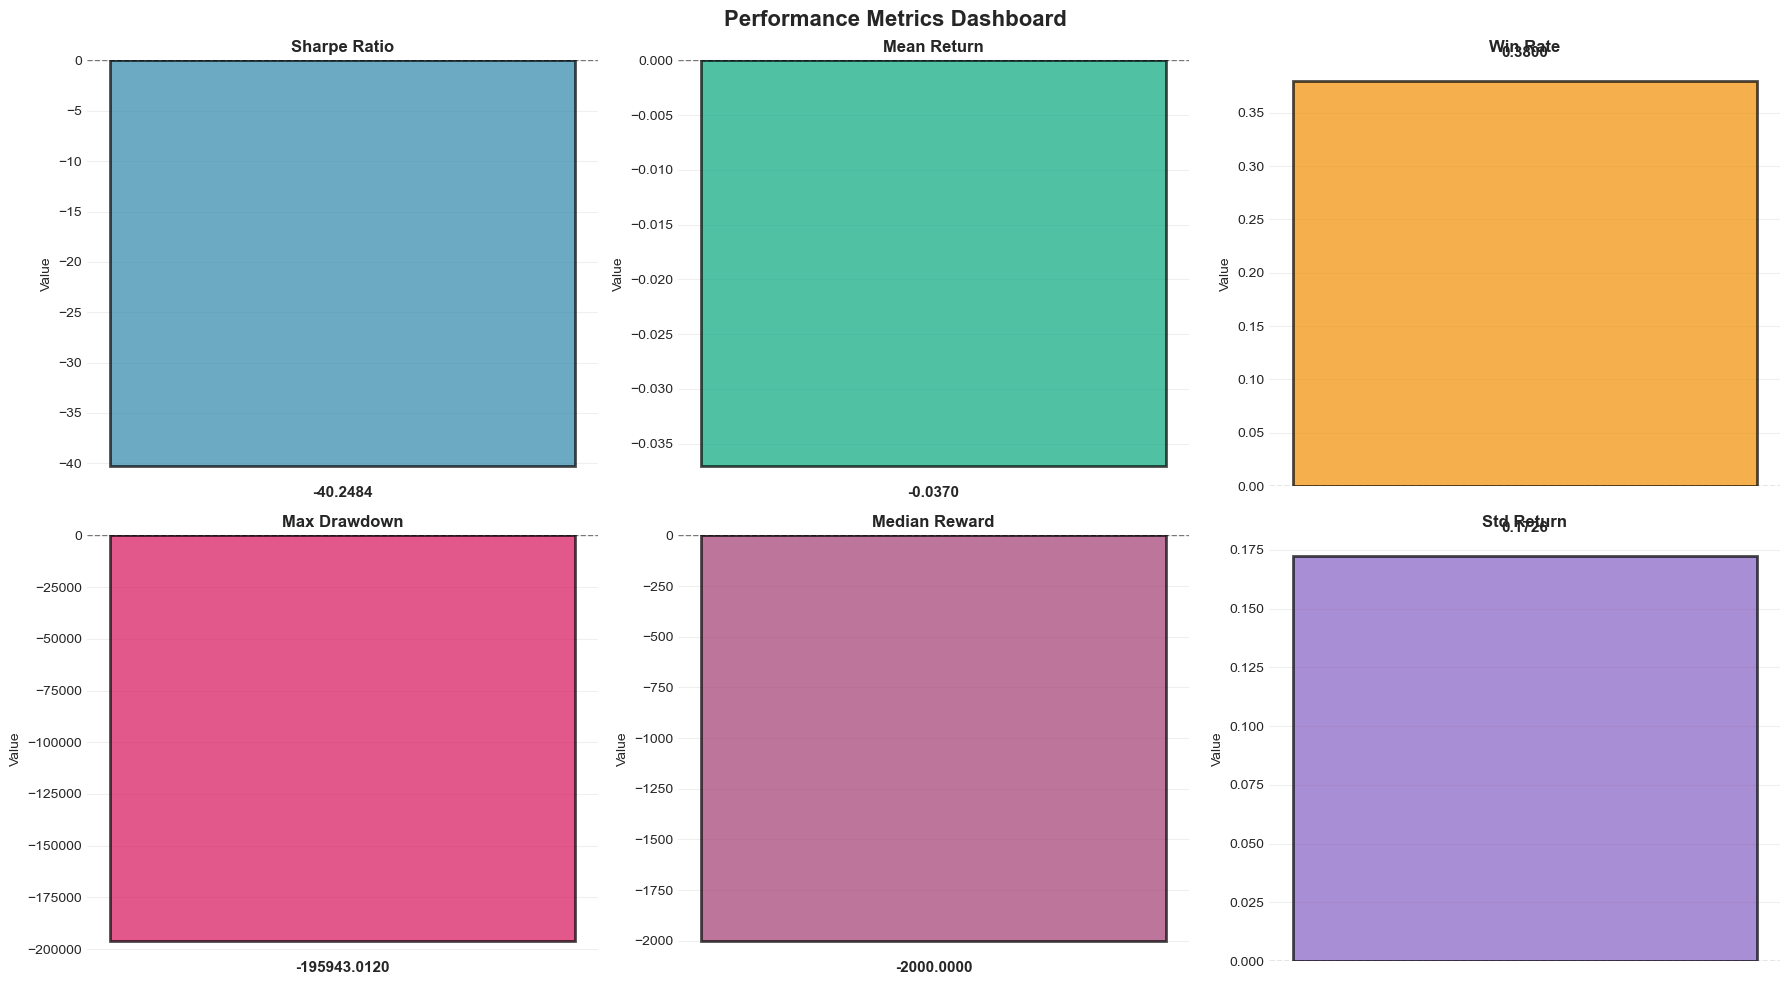

Performance metrics dashboard created!


In [31]:
# Create performance metrics dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Metric names and values
metric_names = ['Sharpe Ratio', 'Mean Return', 'Win Rate', 
                'Max Drawdown', 'Median Reward', 'Std Return']
metric_values = [
    metrics['sharpe_ratio'],
    metrics['mean_return'],
    metrics['win_rate'],
    metrics['max_drawdown'],
    metrics['median_reward'],
    metrics['std_return']
]
metric_colors = ['#2E86AB', '#06A77D', '#F18F01', '#D81159', '#A23B72', '#845EC2']

# Create bar charts for each metric
for idx, (ax, name, value, color) in enumerate(zip(axes.flatten(), metric_names, metric_values, metric_colors)):
    ax.bar([0], [value], color=color, alpha=0.7, edgecolor='black', linewidth=2, width=0.6)
    ax.set_xticks([])
    ax.set_title(name, fontweight='bold', fontsize=12)
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add value label on top of bar
    if value >= 0:
        va_pos = 'bottom'
        y_offset = value * 0.05
    else:
        va_pos = 'top'
        y_offset = value * 0.05
    ax.text(0, value + y_offset, f'{value:.4f}', 
           ha='center', va=va_pos, fontweight='bold', fontsize=11)

plt.suptitle('Performance Metrics Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '03_performance_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Performance metrics dashboard created!")

### 8.2 Backtest Performance Visualization

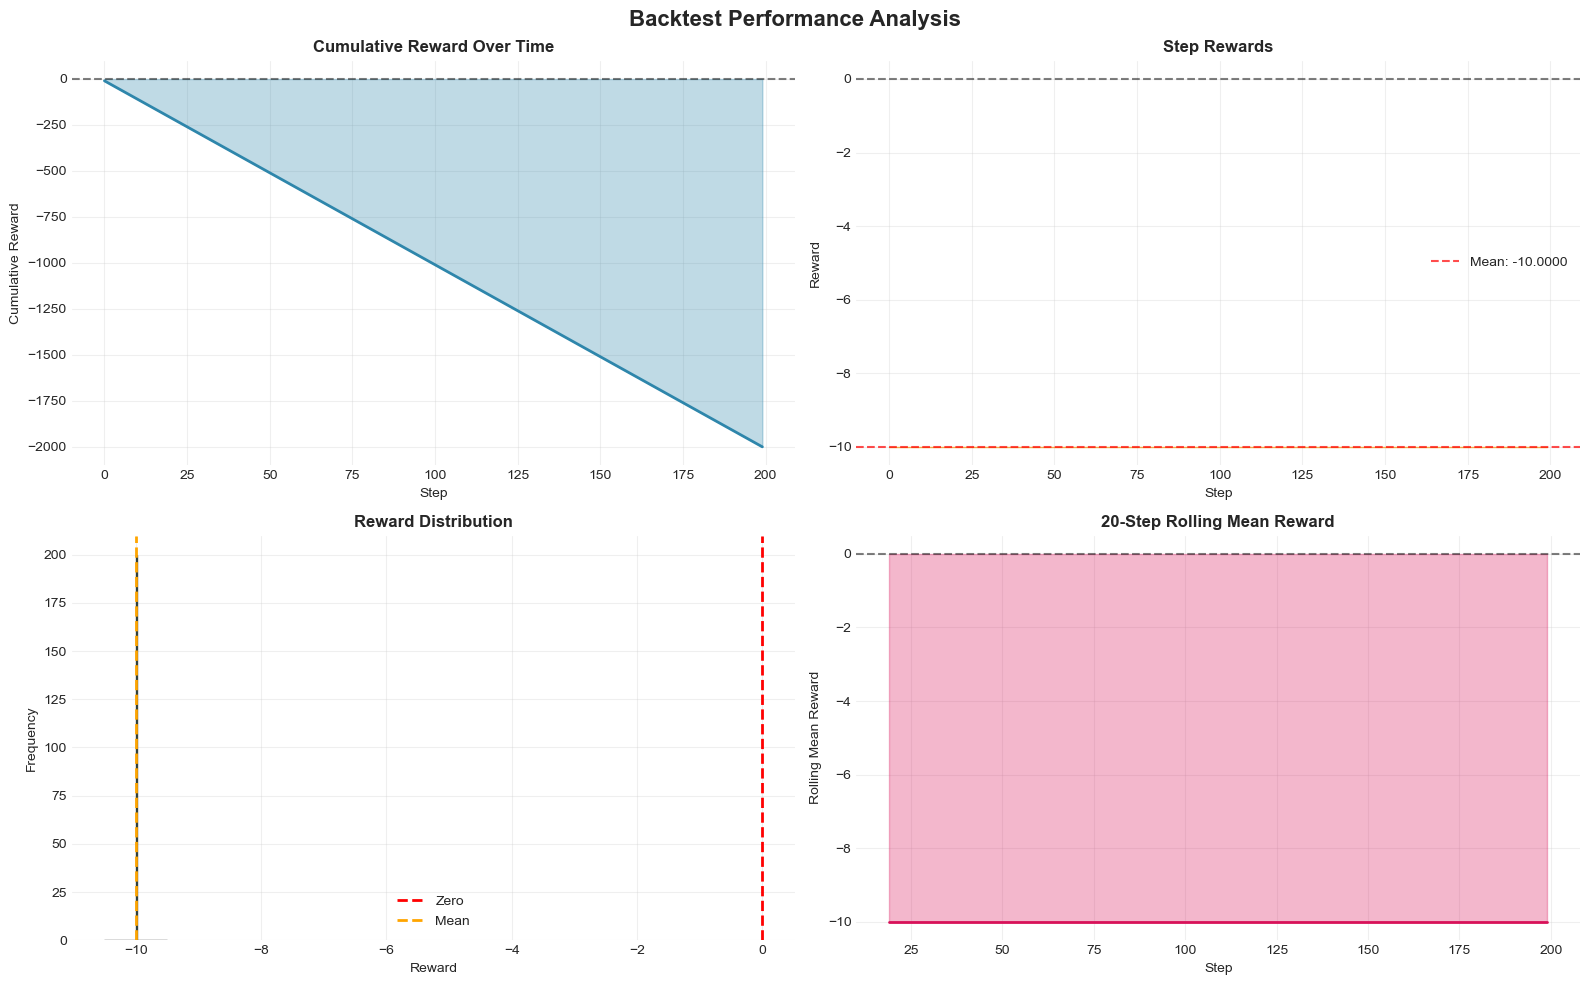

Backtest visualizations created!


In [32]:
# Create backtest visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Cumulative Reward
axes[0, 0].plot(backtest_df['step'], backtest_df['cumulative_reward'], 
               linewidth=2, color='#2E86AB')
axes[0, 0].fill_between(backtest_df['step'], 0, backtest_df['cumulative_reward'], 
                        alpha=0.3, color='#2E86AB')
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Cumulative Reward Over Time', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Step')
axes[0, 0].set_ylabel('Cumulative Reward')
axes[0, 0].grid(True, alpha=0.3)

# 2. Step-by-step Reward
axes[0, 1].plot(backtest_df['step'], backtest_df['reward'], 
               linewidth=1, color='#F18F01', alpha=0.7)
axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0, 1].axhline(y=backtest_df['reward'].mean(), color='red', 
                  linestyle='--', alpha=0.7, label=f'Mean: {backtest_df["reward"].mean():.4f}')
axes[0, 1].set_title('Step Rewards', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Step')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Reward Distribution
axes[1, 0].hist(backtest_df['reward'], bins=50, color='#06A77D', 
               alpha=0.7, edgecolor='black')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1, 0].axvline(x=backtest_df['reward'].mean(), color='orange', 
                  linestyle='--', linewidth=2, label='Mean')
axes[1, 0].set_title('Reward Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Reward')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Rolling Mean Reward (window=20)
rolling_mean = backtest_df['reward'].rolling(window=20).mean()
axes[1, 1].plot(backtest_df['step'], rolling_mean, 
               linewidth=2, color='#D81159')
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1, 1].fill_between(backtest_df['step'], 0, rolling_mean, 
                       alpha=0.3, color='#D81159')
axes[1, 1].set_title('20-Step Rolling Mean Reward', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Step')
axes[1, 1].set_ylabel('Rolling Mean Reward')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Backtest Performance Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '04_backtest_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Backtest visualizations created!")

### 8.3 Interactive Performance Dashboard (Plotly)

In [33]:
# Create interactive Plotly dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Cumulative Reward', 'Step Rewards', 
                   'Reward Distribution', 'Rolling Statistics'),
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
           [{'type': 'histogram'}, {'type': 'scatter'}]]
)

# 1. Cumulative Reward
fig.add_trace(
    go.Scatter(x=backtest_df['step'], y=backtest_df['cumulative_reward'],
              mode='lines', name='Cumulative Reward',
              line=dict(color='#2E86AB', width=2),
              fill='tozeroy'),
    row=1, col=1
)

# 2. Step Rewards
fig.add_trace(
    go.Scatter(x=backtest_df['step'], y=backtest_df['reward'],
              mode='lines', name='Reward',
              line=dict(color='#F18F01', width=1)),
    row=1, col=2
)

# 3. Reward Distribution
fig.add_trace(
    go.Histogram(x=backtest_df['reward'], name='Reward Distribution',
                marker=dict(color='#06A77D', line=dict(color='black', width=1)),
                nbinsx=50),
    row=2, col=1
)

# 4. Rolling statistics
rolling_mean = backtest_df['reward'].rolling(window=20).mean()
rolling_std = backtest_df['reward'].rolling(window=20).std()

fig.add_trace(
    go.Scatter(x=backtest_df['step'], y=rolling_mean,
              mode='lines', name='20-Step Mean',
              line=dict(color='#D81159', width=2)),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=backtest_df['step'], y=rolling_mean + rolling_std,
              mode='lines', name='+1 Std',
              line=dict(color='#D81159', width=1, dash='dash'),
              showlegend=False),
    row=2, col=2
)

fig.add_trace(
    go.Scatter(x=backtest_df['step'], y=rolling_mean - rolling_std,
              mode='lines', name='-1 Std',
              line=dict(color='#D81159', width=1, dash='dash'),
              fill='tonexty', fillcolor='rgba(216, 17, 89, 0.2)'),
    row=2, col=2
)

fig.update_layout(
    title_text="Interactive Performance Dashboard",
    title_font_size=20,
    height=800,
    showlegend=True
)

fig.update_xaxes(title_text="Step", row=1, col=1)
fig.update_xaxes(title_text="Step", row=1, col=2)
fig.update_xaxes(title_text="Reward", row=2, col=1)
fig.update_xaxes(title_text="Step", row=2, col=2)

fig.update_yaxes(title_text="Cumulative Reward", row=1, col=1)
fig.update_yaxes(title_text="Reward", row=1, col=2)
fig.update_yaxes(title_text="Frequency", row=2, col=1)
fig.update_yaxes(title_text="Rolling Mean", row=2, col=2)

fig.write_html(os.path.join(PLOTS_DIR, '05_interactive_dashboard.html'))
fig.show()

print("Interactive dashboard created and saved as HTML!")

Interactive dashboard created and saved as HTML!


### 8.4 Position Analysis

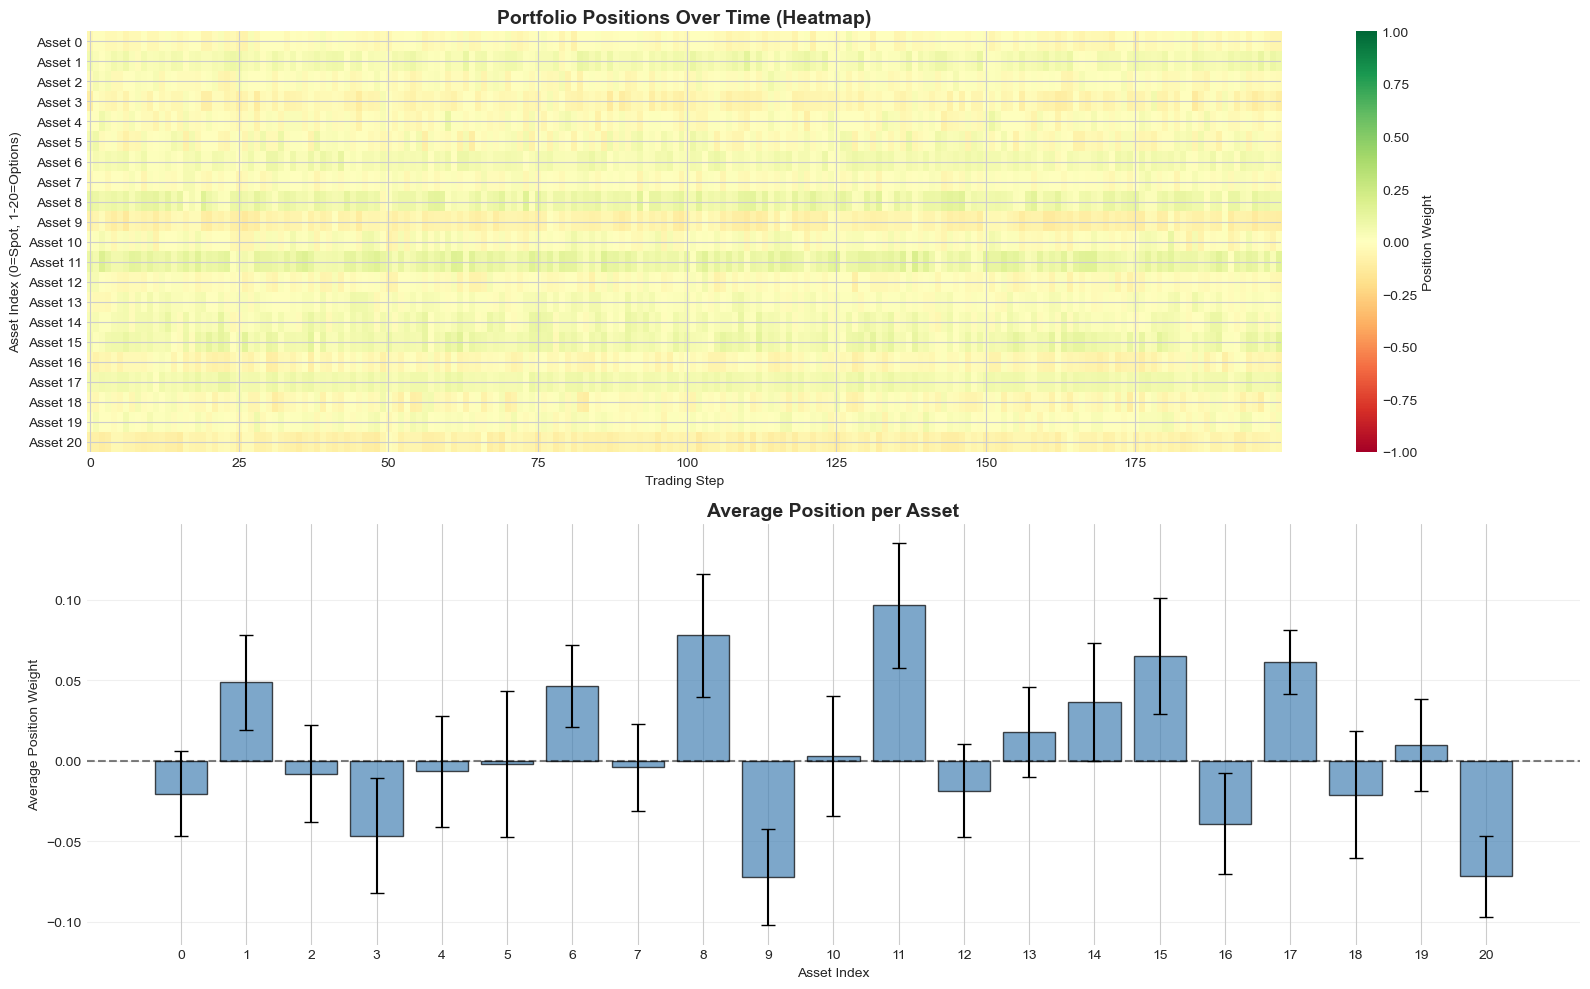

Position analysis visualizations created!


In [34]:
# Extract position data from backtest
positions_data = []
for idx, row in backtest_df.iterrows():
    action = np.array(row['action'])
    if len(action) == 21:
        positions_data.append(action)

if len(positions_data) > 0:
    positions_array = np.array(positions_data)
    
    # Create position heatmap
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # 1. Position Heatmap
    im = axes[0].imshow(positions_array.T, aspect='auto', cmap='RdYlGn', 
                       vmin=-1, vmax=1, interpolation='nearest')
    axes[0].set_title('Portfolio Positions Over Time (Heatmap)', fontweight='bold', fontsize=14)
    axes[0].set_xlabel('Trading Step')
    axes[0].set_ylabel('Asset Index (0=Spot, 1-20=Options)')
    axes[0].set_yticks(range(21))
    axes[0].set_yticklabels([f'Asset {i}' for i in range(21)])
    plt.colorbar(im, ax=axes[0], label='Position Weight')
    
    # 2. Average position per asset
    avg_positions = np.mean(positions_array, axis=0)
    std_positions = np.std(positions_array, axis=0)
    
    x_pos = np.arange(21)
    axes[1].bar(x_pos, avg_positions, yerr=std_positions, 
               alpha=0.7, capsize=5, color='steelblue', edgecolor='black')
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1].set_title('Average Position per Asset', fontweight='bold', fontsize=14)
    axes[1].set_xlabel('Asset Index')
    axes[1].set_ylabel('Average Position Weight')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels([f'{i}' for i in range(21)])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, '06_position_analysis.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Position analysis visualizations created!")
else:
    print("No position data available for visualization")

### 8.5 Statistical Analysis

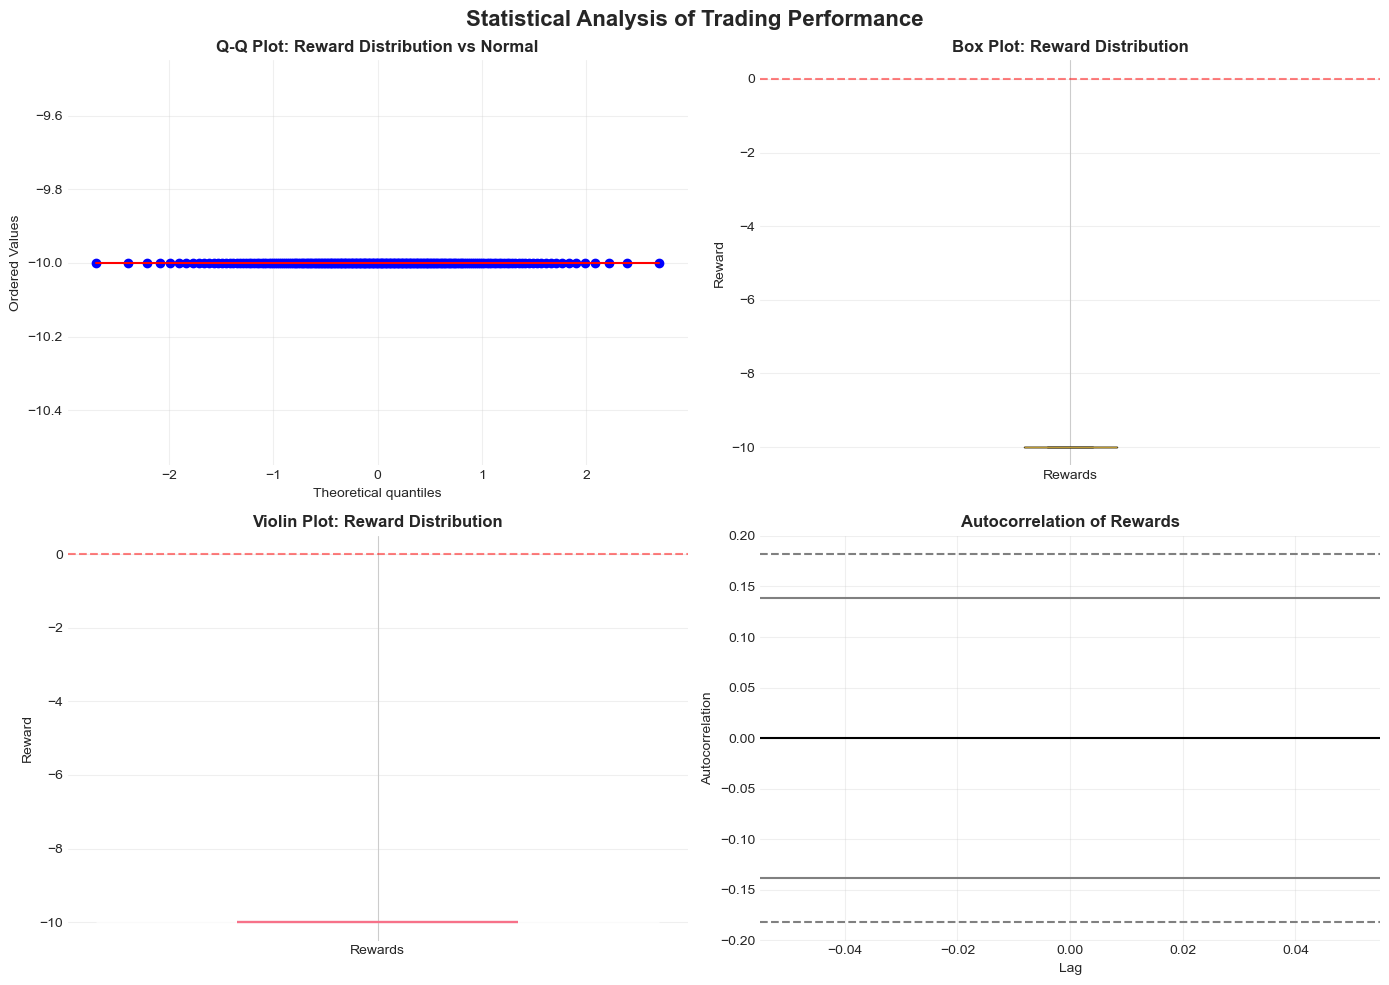

Statistical analysis visualizations created!


In [35]:
# Create statistical analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Q-Q Plot (Normal distribution check)
from scipy import stats
stats.probplot(backtest_df['reward'].dropna(), dist="norm", plot=axes[0, 0])
axes[0, 0].set_title('Q-Q Plot: Reward Distribution vs Normal', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Box Plot
axes[0, 1].boxplot([backtest_df['reward']], labels=['Rewards'])
axes[0, 1].set_title('Box Plot: Reward Distribution', fontweight='bold')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Violin Plot
parts = axes[1, 0].violinplot([backtest_df['reward'].dropna()], 
                              positions=[0], showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('#06A77D')
    pc.set_alpha(0.7)
axes[1, 0].set_title('Violin Plot: Reward Distribution', fontweight='bold')
axes[1, 0].set_ylabel('Reward')
axes[1, 0].set_xticks([0])
axes[1, 0].set_xticklabels(['Rewards'])
axes[1, 0].grid(True, alpha=0.3, axis='y')
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 4. Autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(backtest_df['reward'].dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Autocorrelation of Rewards', fontweight='bold')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Statistical Analysis of Trading Performance', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, '07_statistical_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Statistical analysis visualizations created!")

## 9. Export Results

In [36]:
# Create comprehensive results report
results_dict = {
    'training_timesteps': TRAINING_TIMESTEPS,
    'evaluation_episodes': 100,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    **evaluation_metrics
}

# Convert to DataFrame for better formatting
results_df = pd.DataFrame([results_dict])

# Save to CSV
results_csv_path = os.path.join(REPORTS_DIR, 'training_results.csv')
results_df.to_csv(results_csv_path, index=False)
print(f"Results saved to: {results_csv_path}")

# Save backtest data
backtest_csv_path = os.path.join(REPORTS_DIR, 'backtest_data.csv')
backtest_df.to_csv(backtest_csv_path, index=False)
print(f"Backtest data saved to: {backtest_csv_path}")

# Create detailed text report
report_path = os.path.join(REPORTS_DIR, 'final_report.txt')
with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("POLYHEDGERL - TRAINING AND EVALUATION REPORT\n")
    f.write("="*80 + "\n\n")
    
    f.write(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("TRAINING CONFIGURATION\n")
    f.write("-"*80 + "\n")
    f.write(f"Training Timesteps: {TRAINING_TIMESTEPS:,}\n")
    f.write(f"Evaluation Frequency: {EVAL_FREQ:,}\n")
    f.write(f"Save Frequency: {SAVE_FREQ:,}\n")
    f.write(f"Transaction Cost: {env_config['transaction_cost']}\n")
    f.write(f"Risk Penalty: {env_config['risk_penalty']}\n")
    f.write(f"Episode Length: {env_config['episode_length']} steps\n\n")
    
    f.write("DATA SUMMARY\n")
    f.write("-"*80 + "\n")
    f.write(f"Total Trading Days: {len(spot_data):,}\n")
    f.write(f"Date Range: {spot_data['date'].min()} to {spot_data['date'].max()}\n")
    f.write(f"Total Option Contracts: {len(option_chain):,}\n")
    f.write(f"Asset Universe Size: {len(asset_universe)} options + 1 spot = 21 assets\n\n")
    
    f.write("EVALUATION METRICS\n")
    f.write("-"*80 + "\n")
    for key, value in evaluation_metrics.items():
        if isinstance(value, float):
            f.write(f"{key:.<50} {value:.6f}\n")
        else:
            f.write(f"{key:.<50} {value}\n")
    f.write("\n")
    
    f.write("BACKTEST SUMMARY\n")
    f.write("-"*80 + "\n")
    f.write(f"Total Steps: {len(backtest_df)}\n")
    f.write(f"Final Cumulative Reward: {backtest_df['cumulative_reward'].iloc[-1]:.6f}\n")
    f.write(f"Average Reward per Step: {backtest_df['reward'].mean():.6f}\n")
    f.write(f"Reward Std Deviation: {backtest_df['reward'].std():.6f}\n")
    f.write(f"Min Reward: {backtest_df['reward'].min():.6f}\n")
    f.write(f"Max Reward: {backtest_df['reward'].max():.6f}\n\n")
    
    f.write("FILES GENERATED\n")
    f.write("-"*80 + "\n")
    f.write(f"1. Market Data Analysis: {PLOTS_DIR}/01_market_data_analysis.png\n")
    f.write(f"2. Option Chain Analysis: {PLOTS_DIR}/02_option_chain_analysis.png\n")
    f.write(f"3. Performance Metrics: {PLOTS_DIR}/03_performance_metrics.png\n")
    f.write(f"4. Backtest Analysis: {PLOTS_DIR}/04_backtest_analysis.png\n")
    f.write(f"5. Interactive Dashboard: {PLOTS_DIR}/05_interactive_dashboard.html\n")
    f.write(f"6. Position Analysis: {PLOTS_DIR}/06_position_analysis.png\n")
    f.write(f"7. Statistical Analysis: {PLOTS_DIR}/07_statistical_analysis.png\n")
    f.write(f"8. Training Results: {results_csv_path}\n")
    f.write(f"9. Backtest Data: {backtest_csv_path}\n")
    f.write(f"10. This Report: {report_path}\n\n")
    
    f.write("="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

print(f"Detailed report saved to: {report_path}")
print("\nAll results exported successfully!")

Results saved to: ../results/reports/training_results.csv
Backtest data saved to: ../results/reports/backtest_data.csv
Detailed report saved to: ../results/reports/final_report.txt

All results exported successfully!


## 10. Summary and Conclusions

In [37]:
# Print final summary
print("\n" + "="*80)
print("TRAINING COMPLETE - FINAL SUMMARY")
print("="*80)
print(f"\nTraining Configuration:")
print(f"  - Timesteps: {TRAINING_TIMESTEPS:,}")
print(f"  - Episodes: ~{TRAINING_TIMESTEPS // env_config['episode_length']}")
print(f"  - Assets: 21 (1 spot + 20 options)")

print(f"\nKey Performance Metrics:")
print(f"  - Sharpe Ratio: {metrics['sharpe_ratio']:.4f}")
print(f"  - Mean Return: {metrics['mean_return']:.4f}")
print(f"  - Win Rate: {metrics['win_rate']*100:.2f}%")
print(f"  - Max Drawdown: {metrics['max_drawdown']:.4f}")

print(f"\nFiles Generated:")
print(f"  - {len([f for f in os.listdir(PLOTS_DIR) if f.endswith('.png')])} PNG visualizations")
print(f"  - 1 Interactive HTML dashboard")
print(f"  - 3 CSV/TXT reports")

print(f"\nAll results saved to:")
print(f"  - Plots: {PLOTS_DIR}")
print(f"  - Reports: {REPORTS_DIR}")
print(f"  - Model: {agent.model_dir}")

print("\n" + "="*80)
print("Next Steps:")
print("  1. Review all visualizations in the plots directory")
print("  2. Read the detailed report: results/reports/final_report.txt")
print("  3. For production use, train with 50,000-100,000 timesteps")
print("  4. Explore notebooks 01-08 for more detailed analysis")
print("="*80 + "\n")

print("Thank you for using PolyHedgeRL!")


TRAINING COMPLETE - FINAL SUMMARY

Training Configuration:
  - Timesteps: 5,000
  - Episodes: ~25
  - Assets: 21 (1 spot + 20 options)

Key Performance Metrics:
  - Sharpe Ratio: -40.2484
  - Mean Return: -0.0370
  - Win Rate: 38.00%
  - Max Drawdown: -195943.0120

Files Generated:
  - 6 PNG visualizations
  - 1 Interactive HTML dashboard
  - 3 CSV/TXT reports

All results saved to:
  - Plots: ../results/plots
  - Reports: ../results/reports
  - Model: results/models

Next Steps:
  1. Review all visualizations in the plots directory
  2. Read the detailed report: results/reports/final_report.txt
  3. For production use, train with 50,000-100,000 timesteps
  4. Explore notebooks 01-08 for more detailed analysis

Thank you for using PolyHedgeRL!
